<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/AA_GRUPO3/blob/main/PruebaControl_OCASO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Medición Prueba de Control
Archivo para medir las diferencias de accesos y lecturas en el grupo experimental frente al de control **(OJO, hay que añadir tb la parte de producción y tendencia).**

Diariamente se descargan los datos de la auditoria de los usuarios desde el lunes sábado 13 de Abril de 2024 a las 00:00 horas hasta el momento actual.

In [102]:
pip install unidecode

In [103]:
import os
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt

Defino el grupo experimental como Gr1 y el de control como Gr2.

Hay que tener en cuenta que agentes_inicio son todos los agentes que había el viernes 12 de Abril, se hará un cruce con los agentes del grupo experimental para crear el Gr1.

##Archivos necesarios
Auditoria (descargar todos los días), 1.18 para ver las bajas (descargar todos los días), estructura comercial, grupo control, estandar grupo experimental y formacion grupo experimental.

Subir todos al colab para ser ejecutados.

In [192]:
accesos_usuarios_df = pd.read_excel('/content/2.13_Auditoria_usuarios.xlsx')
agentes_inicio = pd.read_excel('/content/1.18_Estructura_Comercial.xlsx')
Gr2 = pd.read_excel('/content/1.18_Grupo_de_control.xlsx')
est_gr_exp = pd.read_excel('/content/estandar_gr_exp.xlsx')
for_gr_exp = pd.read_excel('/content/formacion_gr_exp.xlsx')
bajas = pd.read_excel('/content/1.18_Bajas.xlsx')

Definición de funciones de limpieza y normalización de los dataframes.

In [105]:
def cols_to_keep(df):
  cols = ['SUCURSAL', 'OFICINA', 'PV', 'CODIGO', 'COD. CALLIDUS/SOLNET', 'LDAP', 'NIF', 'NOMBRE', 'TIPOLOGIA', 'F.ALTA']
  df = df[cols]
  return df

def clean_df(df):
    # Convertir todas las columnas de tipo object a mayúsculas, excepto las especificadas
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(lambda x: unidecode(x.upper()) if isinstance(x, str) else x)

    # Ahora, aplicamos unidecode a los nombres de las columnas
    df.columns = [unidecode(col.upper()) for col in df.columns]
    return df

def date_delete(df):
    df['DIA'] = df['FECHA ESPANOLA'].dt.day
    df['MES'] = df['FECHA ESPANOLA'].dt.month
    # Elimino la columna unnamed y la fecha del servidor, ya que nos vamos a quedar solo con la fecha española
    del_columns = ['UNNAMED: 0', 'FECHA SERVIDOR']
    df.drop(columns=del_columns, inplace=True)
    return df

In [195]:
accesos_usuarios_df = clean_df(accesos_usuarios_df)
accesos_usuarios_df = date_delete(accesos_usuarios_df)
agentes_inicio = cols_to_keep(agentes_inicio)
agentes_inicio = clean_df(agentes_inicio)
Gr2 = cols_to_keep(Gr2)
Gr2 = clean_df(Gr2)
for_gr_exp = clean_df(for_gr_exp)
est_gr_exp = clean_df(est_gr_exp)
bajas = clean_df(bajas)

In [159]:
gr_exp = pd.concat([for_gr_exp, est_gr_exp], ignore_index=True)

In [160]:
Gr1 = agentes_inicio[agentes_inicio['COD. CALLIDUS/SOLNET'].isin(gr_exp['NAME'])]

La columna 'LDAP' es el código que identifica al agente en los archivos Gr1 y Gr2, y 'USERID' en accesos_usuarios_df, los que hay que tener en cuenta al cruzar los dataframes.

Los mezclo para quedarme con todas las columnas y poder hablar de sucursales y otros conceptos.

In [161]:
accesos_gr_exp = pd.merge(accesos_usuarios_df, Gr1, how = 'inner', left_on = 'USERID', right_on = 'LDAP')
accesos_gr_ctrl = pd.merge(accesos_usuarios_df, Gr2, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

##Distintas formas de medición
###Diferencia por Tipos de evento

Vemas cuáles son las diferencias entre los diferentes tipos de evento (LOGIN, LOGOUT, VIEW y READ) entre el grupo de control y el experimental.

In [162]:
dif_eventos_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO'], as_index=False).count()
dif_eventos_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO'], as_index=False).count()

**OJO: ¿cómo puedo cambiar la leyenda?**

<ipython-input-163-4f01a78b919c>:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



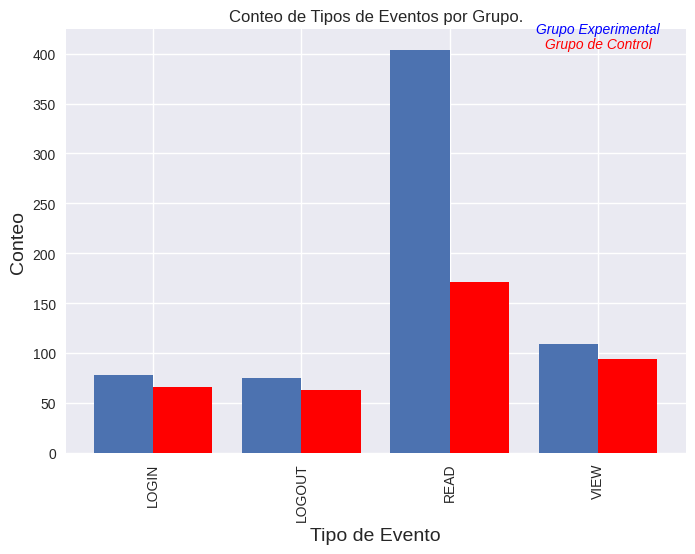

In [163]:
plt.style.use('seaborn')
ax = dif_eventos_exp['USERID'].plot(kind="bar", width=-0.4, rot=0, stacked=True, align='edge')
dif_eventos_ctrl['USERID'].plot(ax=ax, width=0.4, kind="bar",align='edge', color="red")
ax.set_xticklabels(dif_eventos_exp['TIPO EVENTO'])
ax.set_ylabel('Conteo', fontsize = 14)
ax.set_xlabel('Tipo de Evento', fontsize = 14)
# ax.legend(title='DataFrame')
ax.set_title('Conteo de Tipos de Eventos por Grupo.')
ax.text(3, 410, "Grupo de Control",
       fontsize = 10,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "red",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
ax.text(3, 425, "Grupo Experimental",
       fontsize = 10,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "blue",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
plt.autoscale(enable=True, axis='x')
plt.show()

Vamos a contemplar que el grupo experimental es el 100% (la totalidad) para ver las diferencias porcentuales con el grupo de control.

Y sacamos en otra frase a qué número exacto corresponden estos porcentajes.

In [164]:
for i in range(len(dif_eventos_exp)):
  porcentaje = round((dif_eventos_ctrl['USERID'].iloc[i-1]*100)/dif_eventos_exp['USERID'].iloc[i-1],2)
  print('El evento', dif_eventos_exp['TIPO EVENTO'].iloc[i-1], 'del grupo de control supone un ', porcentaje, '% siendo el 100 % lo recogido en el grupo experimental.')
  print('Que se corresponde con', dif_eventos_ctrl['USERID'].iloc[i-1],'registros obtenidos del grupo de control y', dif_eventos_exp['USERID'].iloc[i-1], 'del grupo experimental.\n')

El evento VIEW del grupo de control supone un  86.24 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 94 registros obtenidos del grupo de control y 109 del grupo experimental.

El evento LOGIN del grupo de control supone un  84.62 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 66 registros obtenidos del grupo de control y 78 del grupo experimental.

El evento LOGOUT del grupo de control supone un  84.0 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 63 registros obtenidos del grupo de control y 75 del grupo experimental.

El evento READ del grupo de control supone un  42.33 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 171 registros obtenidos del grupo de control y 404 del grupo experimental.



###Diferencias Tipo Evento - Sucursal
Medimos cuál es el impacto, número de veces que se producen, de cada tipo de evento en cada sucursal (por un lado del grupo experimental y por otro del grupo de control).

In [165]:
import plotly.express as px

dif_sucursales_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_sucursales_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

OJOOOOO, CAMBIAR LO DE VIEW, HAY QUE SACAR BIEN EL TIPO DE EVENTO Y LA SUCURSAL, EN FUNCIÓN DEL MÁXIMO CONSEGUIDO.

In [166]:
print('El evento con más registros es', max(dif_sucursales_exp['TIPO EVENTO']),'en la sucursal', max(dif_sucursales_exp['SUCURSAL']), 'con un total de', max(dif_sucursales_exp['USERID']))

El evento con más registros es VIEW en la sucursal 0512 - VENTAS con un total de 112


In [167]:
dif_sucursales_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_sucursales_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

IGUAL QUE ARRIBA, ESTÁ MAAAAAAAAAAAL

In [168]:
print('El evento con más registros es', max(dif_sucursales_ctrl['TIPO EVENTO']),'en la sucursal', max(dif_sucursales_ctrl['SUCURSAL']), 'con un total de', max(dif_sucursales_ctrl['USERID']))

El evento con más registros es VIEW en la sucursal 0718 - VALDEMORO con un total de 38


####Cambio sucursales por puntos de venta
Sacamos el mismo estudio para los puntos de venta (PV) en vez de las sucursales.

In [169]:
dif_PV_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'PV'], as_index=False).count()

fig = px.scatter(dif_PV_exp, y="TIPO EVENTO", x="PV", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

###Diferencia de accesos por tipología de agente
Medimos cuál es el impacto que tiene cada tipo de agente en los eventos, ¿están accediendo más los agentes en formación (16) o los estándar (37)?

In [170]:
dif_tipologia_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()

In [171]:
fig = px.scatter(dif_tipologia_exp, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [172]:
dif_tipologia_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()
fig = px.scatter(dif_tipologia_ctrl, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

###Agentes en Formación usando los informes
En esta parte del código, vemos qué agentes (del grupo experimental) en formación están usando los informes por sucursal. Código para estar al tanto de cómo ha sido la formación en cascada.

In [173]:
df_for = Gr1[Gr1["TIPOLOGIA"].str.contains("FORMACION")]

accesos_for_exp = pd.merge(accesos_usuarios_df, df_for, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_for_exp = accesos_for_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_for_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes en formación dentro del grupo experimental para saber si están entrando agentes de todas ellas. Observamos que hay 11, luego ya han accedido desde todas.

In [174]:
df_for['SUCURSAL'].unique()

array(['0004 - ALCALA DE HENARES', '0212 - MADRID-G.B.', '0215 - VAGUADA',
       '0222 - VILLALBA', '0233 - ALCOBENDAS', '0234 - COSLADA',
       '0242 - LAS ROSAS', '0278 - MADRID-HORTALEZA',
       '0332 - TORREJON DE ARDOZ', '0462 - LAS ROZAS', '0512 - VENTAS'],
      dtype=object)

####Para el grupo de control
Uso de informes para los agentes en formación del grupo de control. ¿Cuánto usan Callidus los agentes en formación sin informes nuevos relevantes?

In [175]:
df2_for = Gr2[Gr2["TIPOLOGIA"].str.contains("FORMACION")]

accesos_for_ctrl = pd.merge(accesos_usuarios_df, df2_for, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_for_ctrl = accesos_for_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_for_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes en formación dentro del grupo de control para saber si están entrando agentes de todas ellas. Observamos que hay 12 y solo se ha accedido desde 8 **(cambiar diariamente si esto cambia)**.

In [176]:
df2_for['SUCURSAL'].unique()

array(['0018 - ARANJUEZ', '0214 - MOSTOLES', '0218 - FUENLABRADA',
       '0220 - LEGANES', '0221 - ALCORCON', '0223 - PARLA',
       '0255 - GETAFE', '0277 - MADRID-BUENAVISTA', '0312 - VALLECAS',
       '0412 - CARABANCHEL', '0442 - MADRID-CIUDAD DE LOS ANGELES',
       '0718 - VALDEMORO'], dtype=object)

###Agentes Estándar usando los informes
En esta parte del código, vemos qué agentes (del grupo experimental) de tipo estándar, están usando los informes por sucursal. Código para comparar con los de formación y ver si es mejor contar de primera mano la información o la formación en cascada y, medir qué tipología de agente encuentra más relevante los informes.

In [177]:
df_est = Gr1[Gr1["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_exp = pd.merge(accesos_usuarios_df, df_est, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_exp = accesos_est_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes estándar dentro del grupo experimental para saber si están entrando agentes de todas ellas. Observamos que hay 10, faltan por acceder los agentes de '0215 - VAGUADA' **(cambiar si se modifica)**.

In [178]:
df_est['SUCURSAL'].unique()

array(['0004 - ALCALA DE HENARES', '0212 - MADRID-G.B.', '0215 - VAGUADA',
       '0222 - VILLALBA', '0233 - ALCOBENDAS', '0234 - COSLADA',
       '0242 - LAS ROSAS', '0278 - MADRID-HORTALEZA',
       '0332 - TORREJON DE ARDOZ', '0462 - LAS ROZAS'], dtype=object)

Voy a sacar el número de agentes que hay en esta sucursal, para saber si es importante esta falta de accesos o no. Hay dos agentes en esta sucursal, no supone mucho impacto.

In [179]:
vaguada_est = df_est[df_est['SUCURSAL'].str.contains('VAGUADA')]

vaguada_est

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA
1648,0215 - VAGUADA,0215 - VAGUADA,215,9270,Z0157154T0000,Z0157154T0000,Z0157154T,CLAUDIA LIZETH VALENZUELA MALDONADO,37 - AGENTE ESTANDAR,2023-02-10
1650,0215 - VAGUADA,0215 - VAGUADA,215,9274,Y7170466T0000,Y7170466T0000,Y7170466T,ADRIANA OLMOS ARAGORT,37 - AGENTE ESTANDAR,2023-04-18


####Para el grupo de control
Uso de informes para los agentes estándar del grupo de control. ¿Cuánto usan Callidus estos agentes sin informes nuevos relevantes? ¿Usan Callidus como herramienta de ayuda?

In [180]:
df2_est = Gr2[Gr2["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_ctrl = pd.merge(accesos_usuarios_df, df2_est, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_ctrl = accesos_est_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes estándar dentro del grupo de control para saber si están entrando agentes de todas ellas. Observamos que hay 11 y solo se ha accedido desde 8 sucursales **(cambiar si se modifica)**.

In [181]:
df2_est['SUCURSAL'].unique()

array(['0214 - MOSTOLES', '0218 - FUENLABRADA', '0220 - LEGANES',
       '0221 - ALCORCON', '0223 - PARLA', '0255 - GETAFE',
       '0277 - MADRID-BUENAVISTA', '0312 - VALLECAS',
       '0412 - CARABANCHEL', '0442 - MADRID-CIUDAD DE LOS ANGELES',
       '0718 - VALDEMORO'], dtype=object)

###Impacto por agente
¿Cuántos agentes del grupo experimental están haciendo uso de los informes? ¿Cuáles de ellos acceden a Callidus? ¿Es un número alto?

Primero para los agentes en formación del grupo experimental.

In [182]:
agentes_for_exp = accesos_for_exp.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_for_exp, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [183]:
agentes_est_exp = accesos_est_exp.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_exp, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

Cuántos agentes están usando los informes, por tipología y en su totalidad.

In [184]:
print('Hay', agentes_for_exp['NOMBRE USUARIO'].nunique(), 'agentes en formación del grupo experimental usando los informes y', agentes_est_exp['NOMBRE USUARIO'].nunique(), 'agentes estándar, es decir, un total de', agentes_for_exp['NOMBRE USUARIO'].nunique() + agentes_est_exp['NOMBRE USUARIO'].nunique(), 'agentes.')

Hay 18 agentes en formación del grupo experimental usando los informes y 15 agentes estándar, es decir, un total de 33 agentes.


Totalidad de agentes en el grupo experimental y según la tipología.

In [185]:
print('Hay', df_for['NOMBRE'].nunique(), 'agentes en formación y', df_est['NOMBRE'].nunique(), 'agentes estándar en el grupo experimental, es decir, un total de', df_for['NOMBRE'].nunique() + df_est['NOMBRE'].nunique(), 'agentes.')

Hay 51 agentes en formación y 28 agentes estándar en el grupo experimental, es decir, un total de 79 agentes.


Medimos porcentualmente qué representan estos datos.

In [186]:
dif_for_exp = round((100*agentes_for_exp['NOMBRE USUARIO'].nunique())/df_for['NOMBRE'].nunique(),2)

dif_est_exp = round((100*agentes_est_exp['NOMBRE USUARIO'].nunique())/df_est['NOMBRE'].nunique(),2)

total_usando = agentes_for_exp['NOMBRE USUARIO'].nunique() + agentes_est_exp['NOMBRE USUARIO'].nunique()
total_exp = (df_for['NOMBRE'].nunique() + df_est['NOMBRE'].nunique())

dif_total_exp = round((100*total_usando)/total_exp,2)

print('Hay', dif_for_exp, '% de agentes en formación y', dif_est_exp, '% agentes estándar usando los informes, es decir, un total de', dif_total_exp, '% de agentes.')

Hay 35.29 % de agentes en formación y 53.57 % agentes estándar usando los informes, es decir, un total de 41.77 % de agentes.


####Para el grupo de control

In [187]:
agentes_for_ctrl = accesos_for_ctrl.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_for_ctrl, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [188]:
agentes_est_ctrl = accesos_est_ctrl.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_ctrl, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.show()

In [189]:
print('Hay', agentes_for_ctrl['NOMBRE USUARIO'].nunique(), 'agentes en formación usando Callidus del grupo experimental y', agentes_est_ctrl['NOMBRE USUARIO'].nunique(), 'agentes estándar, es decir, un total de', agentes_for_ctrl['NOMBRE USUARIO'].nunique() + agentes_est_ctrl['NOMBRE USUARIO'].nunique(), 'agentes.')

Hay 14 agentes en formación usando Callidus del grupo experimental y 13 agentes estándar, es decir, un total de 27 agentes.


In [190]:
print('Hay', df2_for['NOMBRE'].nunique(), 'agentes en formación y', df2_est['NOMBRE'].nunique(), 'agentes estándar en el grupo de control, es decir, un total de', df2_for['NOMBRE'].nunique() + df2_est['NOMBRE'].nunique(), 'agentes.')

Hay 65 agentes en formación y 20 agentes estándar en el grupo de control, es decir, un total de 85 agentes.


Medimos los porcentajes.

In [191]:
dif_for_ctrl = round((100*agentes_for_ctrl['NOMBRE USUARIO'].nunique())/df2_for['NOMBRE'].nunique(),2)

dif_est_ctrl = round((100*agentes_est_exp['NOMBRE USUARIO'].nunique())/df2_est['NOMBRE'].nunique(),2)

total_usando_ctrl = agentes_for_ctrl['NOMBRE USUARIO'].nunique() + agentes_est_ctrl['NOMBRE USUARIO'].nunique()
total_ctrl = (df2_for['NOMBRE'].nunique() + df2_est['NOMBRE'].nunique())

dif_total_ctrl = round((100*total_usando_ctrl)/total_ctrl,2)

print('Hay', dif_for_ctrl, '% de agentes en formación y', dif_est_ctrl, '% agentes estándar usando los informes, es decir, un total de', dif_total_ctrl, '% de agentes.')

Hay 21.54 % de agentes en formación y 75.0 % agentes estándar usando los informes, es decir, un total de 31.76 % de agentes.


###Medimos las Bajas
Vamos a ver los agentes de ambos grupos que se han dado de baja hasta el momento, a partir del 1.18 la parte de agentes inactivos que será subida diariamente.

####Bajas de los agentes del grupo experimental

In [199]:
bajas_exp = Gr1[Gr1['NOMBRE'].isin(bajas['NOMBRE'].unique())]

bajas_exp

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA


####Bajas de los agentes del grupo de control

In [200]:
bajas_ctrl = Gr2[Gr2['NOMBRE'].isin(bajas['NOMBRE'].unique())]

bajas_ctrl

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA
18,0220 - LEGANES,0220 - LEGANES,220,9000,14077527D0000,14077527D0000,14077527D,YRIS DEL CARMEN GAMBOA GONZALEZ,16 - AGENTE EN FORMACION,2024-03-18


**OTROS ESTUDIOS QUE SE PUEDEN HACER:**



*   Filtrar solo por tipo de evento ¿READ  o VIEW o qué evento? para ver en una gráfica el impacto por sucursales (u oficinas o puntos de venta).
*   